# LineMood Dataset esplorazione
Questo notebook serve ad esplorare il dataset linemod, per farlo ci si avvale di un custom data dataloader

## 1. Import delle librerie necessarie

In [14]:
import sys
from pathlib import Path
import torch
import os
import yaml

sys.path.insert(0, str(Path.cwd().parent))
from config import Config
from utils.download_dataset import download_linemod_dataset
from dataset.linemod_base import LineMODDatasetBase
from dataset.linemod_yolo import LineMODYOLODataset
from dataset.linemod_pose import LineMODPoseDataset


# Device detection (minimal output)
device = Config.DEVICE
print(f"Device: {device}")

Device: mps


## 2. Scarica il Dataset

Usa questa cella per scaricare il dataset LineMOD preprocessato.

**Nota:** Il download può richiedere alcuni minuti.

In [5]:
output_dir = Config.DATASETS_DIR
dataset_path = Config.LINEMOD_ROOT
if os.path.exists(dataset_path) and os.path.isdir(dataset_path) and len(os.listdir(dataset_path)) > 0:
    print("Dataset presente.")
else:
    download_linemod_dataset(output_dir=output_dir)

Dataset presente.


## 3. Esplora la struttura del dataset

In [6]:
data_dir = Config.DATASETS_DIR
if data_dir.exists():
    for item in sorted(data_dir.rglob('*')):
        if item.is_dir():
            level = len(item.relative_to(data_dir).parts)
            if level <= 2:
                indent = '  ' * level
                print(f"{indent}{item.name}/")
else:
    print("Dataset directory not found.")

  Linemod_preprocessed/
    data/
    models/
    segnet_results/


## 4. Esplora il contenuto di gt.yml e info.yml

Questa sezione cerca e mostra i contenuti dei file di annotazione `gt.yml` e `info.yml` del dataset LineMOD:


- **`gt.yml`**: contiene le annotazioni ground truth degli oggetti per ogni immagine (es. bounding box, pose, ecc.). La cella stampa il contenuto del primo oggetto annotato per il primo sample disponibile, utile per capire la struttura delle annotazioni.
- **`info.yml`**: contiene informazioni aggiuntive sulle immagini (es. dimensioni, parametri di acquisizione, ecc.). Anche qui viene stampato il contenuto del primo sample disponibile.


Questa esplorazione è utile per verificare rapidamente la struttura e la correttezza dei file di annotazione prima di usarli nel data loader o nei modelli.

In [10]:
gt_file = next(Config.LINEMOD_ROOT.rglob('gt.yml'), None)
info_file = next(Config.LINEMOD_ROOT.rglob('info.yml'), None)

if gt_file:
    with open(gt_file, 'r') as f:
        gt_data = yaml.safe_load(f)
        if isinstance(gt_data, dict):
            first_key = list(gt_data.keys())[0]
            print(f"gt.yml - Sample ID: {first_key}\n{gt_data[first_key][0] if isinstance(gt_data[first_key], list) else gt_data[first_key]}")

if info_file:
    with open(info_file, 'r') as f:
        info_data = yaml.safe_load(f)
        if isinstance(info_data, dict):
            first_key = list(info_data.keys())[0]
            print(f"info.yml - Sample ID: {first_key}\n{info_data[first_key][0] if isinstance(info_data[first_key], list) and len(info_data[first_key]) > 0 else info_data[first_key]}")

gt.yml - Sample ID: 0
{'cam_R_m2c': [-0.061734, 0.99215603, -0.108696, 0.77404898, -0.0211604, -0.63277203, -0.630108, -0.123199, -0.76667202], 'cam_t_m2c': [103.57929656, 49.49001985, 1040.43577706], 'obj_bb': [344, 228, 77, 84], 'obj_id': 4}
info.yml - Sample ID: 0
{'cam_K': [572.4114, 0.0, 325.2611, 0.0, 573.57043, 242.04899, 0.0, 0.0, 1.0], 'depth_scale': 1.0}


## 5. Carica il Dataset con CustomDataset

In [ ]:
dataset_root = Config.LINEMOD_ROOT
train_dataset = LineMODDatasetBase(dataset_root, split='train')
test_dataset = LineMODDatasetBase(dataset_root, split='test')
print(f"Train: {len(train_dataset)} | Test: {len(test_dataset)}")

Train: 2373 | Test: 13407


In [ ]:
train_dataset = LineMODPoseDataset(dataset_root, split='train')
test_dataset = LineMODPoseDataset(dataset_root, split='test')
print(f"Train: {len(train_dataset)} | Test: {len(test_dataset)}")

Train: 2373 | Test: 13407


In [20]:
train_dataset = LineMODYOLODataset(dataset_root, split='train')
test_dataset = LineMODYOLODataset(dataset_root, split='test')
print(f"Train: {len(train_dataset)} | Test: {len(test_dataset)}")

Train: 2373 | Test: 13407


### 5.1 Test Fix: Verifica caricamento multipli oggetti per sample_id

In [21]:
# Test: verifica caricamento multipli oggetti
folder_02_samples = [(i, s) for i, s in enumerate(train_dataset.samples) if s[0] == 2]
if folder_02_samples:
    for test_idx in range(min(1, len(folder_02_samples))):
        idx, (folder_id, sample_id) = folder_02_samples[test_idx]
        sample = train_dataset[idx]
        print(f"02: {sample['num_objects']} oggetti")
folder_01_samples = [(i, s) for i, s in enumerate(train_dataset.samples) if s[0] == 1]
if folder_01_samples:
    idx, (folder_id, sample_id) = folder_01_samples[0]
    sample = train_dataset[idx]
    print(f"01: {sample['num_objects']} oggetti")

02: 9 oggetti
01: 1 oggetti


## 6. Visualizza campioni del dataset

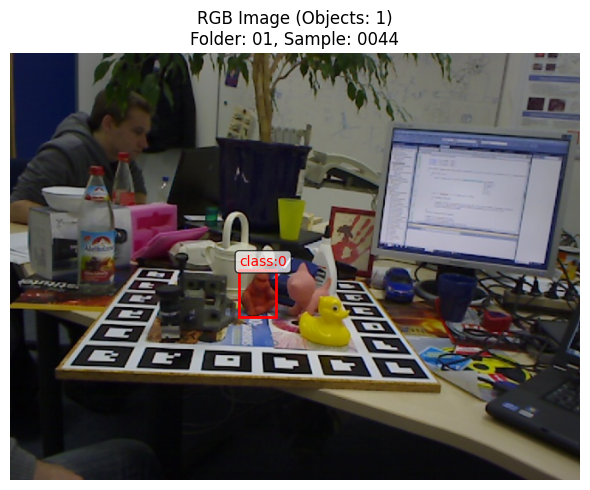


🎯 Found 1 object(s) in this image:
  Object #1: class_id=0, bbox=[0.43359375, 0.5635416666666667, 0.0640625, 0.11041666666666666]


In [23]:
def visualize_sample(sample):
    """
    Visualizza un campione del dataset con TUTTI i bounding box (compatibile con LineMODYOLODataset).

    Args:
        sample: Un dizionario contenente i dati del campione
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    # Visualizza l'immagine (PIL Image)
    img = np.array(sample['image'])
    ax.imshow(img)
    ax.set_title(f"RGB Image (Objects: {sample['num_objects']})\nFolder: {sample['folder_id']:02d}, Sample: {sample['sample_id']:04d}")
    ax.axis('off')

    # Draw ALL bounding boxes with different colors
    colors = ['r', 'g', 'b', 'y', 'c', 'm', 'orange', 'purple']
    if sample['num_objects'] > 0:
        for i, (bbox, class_id) in enumerate(zip(sample['bboxes'], sample['class_ids'])):
            # bbox formato YOLO: [x_center, y_center, width, height] normalizzati
            x_c, y_c, w, h = bbox
            img_h, img_w = img.shape[0], img.shape[1]
            x = (x_c - w/2) * img_w
            y = (y_c - h/2) * img_h
            w_pix = w * img_w
            h_pix = h * img_h
            color = colors[i % len(colors)]
            rect = Rectangle((x, y), w_pix, h_pix, linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
            # Add class ID label
            ax.text(x, y-5, f"class:{class_id}", color=color, fontsize=10,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

    plt.tight_layout()
    plt.show(block=True)

    # Stampa informazioni su tutti gli oggetti
    print(f"\n🎯 Found {sample['num_objects']} object(s) in this image:")
    for i, (bbox, class_id) in enumerate(zip(sample['bboxes'], sample['class_ids'])):
        print(f"  Object #{i+1}: class_id={class_id}, bbox={bbox}")

# Esempio: visualizza il primo sample del train_dataset
visualize_sample(train_dataset[4])